**Importing Libraries**

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score


**Loading The Datasets**

In [6]:
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')


**Merging The Data**

In [8]:
merged_data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

In [9]:
print("Merged Data Preview:")
print(merged_data.head())

Merged Data Preview:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue  Price_x     CustomerName         Region  SignupDate  \
0      300.68   300.68   Andrea Jenkins         Europe  2022-12-03   
1      300.68   300.68  Brittany Harvey           Asia  2024-09-04   
2      300.68   300.68  Kathryn Stevens         Europe  2024-04-04   
3      601.36   300.68  Travis Campbell  South America  2024-04-11   
4      902.04   300.68    Timothy Perez         Europe  2022-03-15   

                       ProductName     Category  Price_y  
0  ComfortLiving Bluetooth Speaker  Electronics   300.68  
1  ComfortLiv

In [13]:
print("Duplicates in Transactions:", transactions.duplicated().sum())
print("Duplicates in Customers:", customers.duplicated().sum())
print("Duplicates in Products:", products.duplicated().sum())


Duplicates in Transactions: 0
Duplicates in Customers: 0
Duplicates in Products: 0


**Preprocess The Data**

In [10]:
clustering_data = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'Region': 'first'
}).reset_index()

# Convert the 'Region' column to dummy variables
clustering_data = pd.get_dummies(clustering_data, columns=['Region'])
# Drop 'CustomerID' as it is not needed for clustering
features = clustering_data.drop(columns=['CustomerID'])
# Display the feature set
print("Feature Set for Clustering:")
print(features.head())

Feature Set for Clustering:
   TotalValue  Quantity  Region_Asia  Region_Europe  Region_North America  \
0     3354.52        12        False          False                 False   
1     1862.74        10         True          False                 False   
2     2725.38        14        False          False                 False   
3     5354.88        23        False          False                 False   
4     2034.24         7         True          False                 False   

   Region_South America  
0                  True  
1                 False  
2                  True  
3                  True  
4                 False  


**Standardize The Features**

In [15]:
from sklearn.preprocessing import StandardScaler

# Standardize the feature set
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
print("Scaled Features (First 5 Rows):")
print(scaled_features[:5])

Scaled Features (First 5 Rows):
[[-0.06170143 -0.12203296 -0.53279543 -0.57928445 -0.54831888  1.54041597]
 [-0.87774353 -0.44800021  1.87689298 -0.57928445 -0.54831888 -0.6491753 ]
 [-0.40585722  0.20393428 -0.53279543 -0.57928445 -0.54831888  1.54041597]
 [ 1.03254704  1.67078689 -0.53279543 -0.57928445 -0.54831888  1.54041597]
 [-0.78392861 -0.93695108  1.87689298 -0.57928445 -0.54831888 -0.6491753 ]]


** Davies-Bouldin Index (DB Index)-To Find Optimal Number Of Clusters**

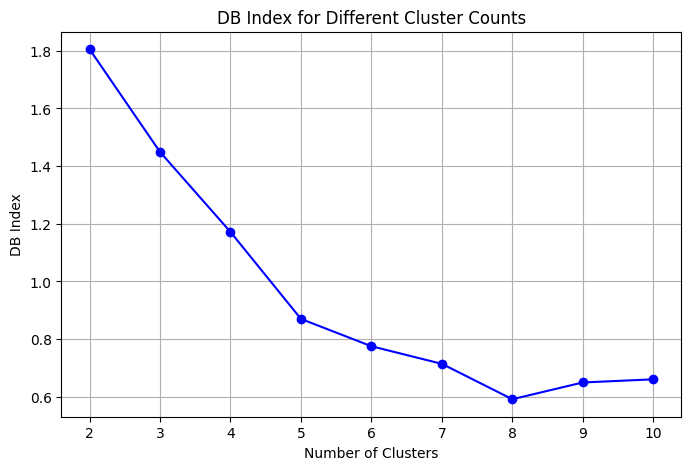

In [16]:
db_indices = []
# Test cluster sizes from 2 to 10
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)  # Fit the model and predict clusters
    db_index = davies_bouldin_score(scaled_features, labels)  # Calculate DB Index
    db_indices.append(db_index)

# Plot the DB Index values for different cluster counts
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), db_indices, marker='o', linestyle='-', color='blue')
plt.title('DB Index for Different Cluster Counts')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.grid()
plt.show()


**Clustering**

In [17]:
optimal_clusters = db_indices.index(min(db_indices)) + 2
print(f"Optimal Number of Clusters: {optimal_clusters}")
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clustering_data['Cluster'] = kmeans.fit_predict(scaled_features)
print("Clustering Results (First 5 Rows):")
print(clustering_data.head())


Optimal Number of Clusters: 8
Clustering Results (First 5 Rows):
  CustomerID  TotalValue  Quantity  Region_Asia  Region_Europe  \
0      C0001     3354.52        12        False          False   
1      C0002     1862.74        10         True          False   
2      C0003     2725.38        14        False          False   
3      C0004     5354.88        23        False          False   
4      C0005     2034.24         7         True          False   

   Region_North America  Region_South America  Cluster  
0                 False                  True        1  
1                 False                 False        3  
2                 False                  True        1  
3                 False                  True        5  
4                 False                 False        3  


**Visulasing The Clusters**

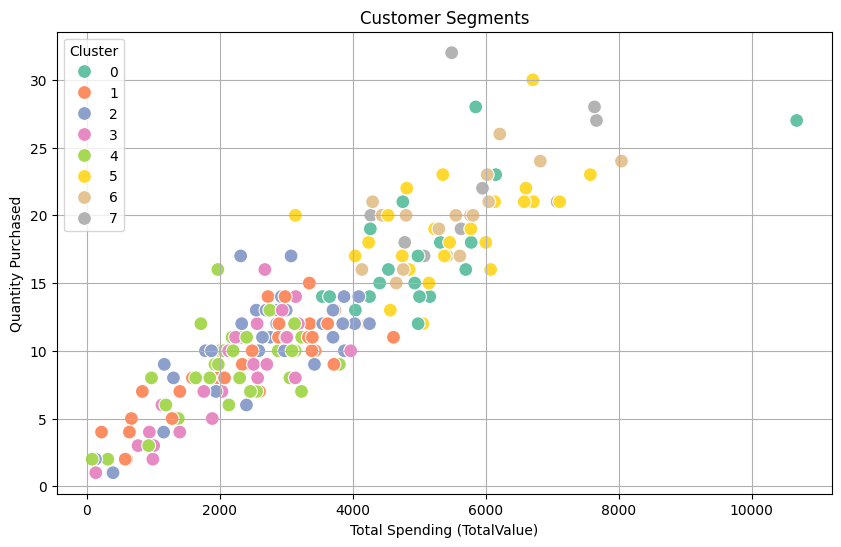

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=clustering_data,
    x='TotalValue',
    y='Quantity',
    hue='Cluster',
    palette='Set2',
    s=100
)
plt.title('Customer Segments')
plt.xlabel('Total Spending (TotalValue)')
plt.ylabel('Quantity Purchased')
plt.legend(title='Cluster')
plt.grid()
plt.show()


**Saving Clustering File**

In [19]:
clustering_data.to_csv('Clustering_Results.csv', index=False)
print("Clustering results saved to 'Clustering_Results.csv'")

Clustering results saved to 'Clustering_Results.csv'
